In [1]:
import pandas as pd
import cv2
import sys
import os

sys.path.append("../../")

from src.dataset3D import MRIDataset3D
from src.utils3D  import PreProcessing3Dto2D
#utils.set_seed(42)

preprocessor3D = PreProcessing3Dto2D(binarize_threshold=0.15)
# 📂 Carga de CSV
results_dir = '../../results/preprocessed_data/'
df_train = pd.read_csv(os.path.join(results_dir, 'df_train.csv'))
df_test = pd.read_csv(os.path.join(results_dir, 'df_test.csv'))
df_train.head(2)

,filename,Noise,Zipper,Positioning,Banding,Motion,Contrast,Distortion,path,patient_id,dim_x,dim_y,dim_z,spacing_x,spacing_y,spacing_z,view
0,LISA_0001_LF_axi.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,36,120,146,5.0,1.5,1.5,axi
1,LISA_0001_LF_cor.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,40,120,120,5.0,1.5,1.5,cor


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, Orientation
import copy

def extract_dense_near_max_slices_tile(volume: torch.Tensor, tile_rows: int, tile_cols: int, view_axis: str = "sag",
                                       normalize=True, std_factor=0.5, kernel_size: int = 3, debug : bool = False , reorientar : bool = True,
                                       threshold : float = 0.1):
    """
    Encuentra las slices consecutivas con mayor contenido cerebral usando operaciones morfológicas
    con un kernel de tamaño personalizado para limpiar ruido. Extrae un bloque 2D (NxM) como mosaico.
    """
    assert volume.ndim == 4 and volume.shape[0] == 1, "Expected shape (1, D, H, W)"
    slices = volume[0].cpu().numpy()
    D, H, W = slices.shape
    total_slices = tile_rows * tile_cols
    if reorientar:
       slices = preprocessor3D.reorientation(slices, view_axis)
      
    num_slices = slices.shape[0]

    # Crear estructura morfológica (kernel cuadrado)
    values = []
    slices_mask = []

    for i in range(num_slices):
        original = copy.deepcopy(slices[i])
        mask, ratio     = preprocessor3D.morphological_operations(original)
        slices_mask.append(mask)
        values.append(np.count_nonzero(mask))
    values = np.array(values)
    slices_mask_filtered = [mask*0 if (np.count_nonzero(mask)/(H*W))<threshold else mask for mask in slices_mask]

    # Evaluar bloques de slices consecutivos
    scores = [(i, values[i:i + total_slices].sum()) for i in range(num_slices - total_slices + 1)]
    score_array = np.array([s for _, s in scores])
    max_score = score_array.max()
    std = score_array.std()
    lower = max_score - std_factor * std
    filtered = [(i, s) for i, s in scores if s >= lower]

    # Elegir el bloque más centrado
    center_idx = num_slices // 2
    # Elegir bloque más centrado respecto al volumen total
    max_idx = int(values.argmax())
    if not filtered:
        best_start = int(score_array.argmax())
    else:
        #center_idx = num_slices // 2
        best_start = min(filtered, key=lambda i: abs((i[0] + total_slices // 2) - max_idx))[0]

    selected = slices[best_start:best_start + total_slices]
    mask_selected   = slices_mask[best_start:best_start + total_slices]
    mask_selected_filtered  = slices_mask_filtered[best_start:best_start + total_slices]

    H, W = selected.shape[1:]
    canvas = np.zeros((tile_rows * H, tile_cols * W), dtype=np.float32)
    canvas_mask = np.zeros((tile_rows * H, tile_cols * W), dtype=np.float32)
    canvas_mask_filtered = np.zeros((tile_rows * H, tile_cols * W), dtype=np.float32)

    if debug:
      print("values max_idx:",max_idx)
      print("score_array:",score_array)
      print("max_score:",max_score)
      print("std:",std)
      print("filtered:",filtered)
      print("lower:",lower)
      print("best_start:",best_start)
      print("selected:",values[best_start:best_start + total_slices])



    for idx in range(total_slices):
        row = idx // tile_cols
        col = idx % tile_cols
        canvas[row * H:(row + 1) * H, col * W:(col + 1) * W] = selected[idx]
        canvas_mask[row * H:(row + 1) * H, col * W:(col + 1) * W] = mask_selected[idx]
        canvas_mask_filtered[row * H:(row + 1) * H, col * W:(col + 1) * W] = mask_selected_filtered[idx]
    if normalize:
        if debug:
          print("canvas.min():",canvas.min())
          print("canvas.max():",canvas.max())
        #canvas[canvas>1] = 1
        canvas -= canvas.min()
        canvas /= (canvas.max() + 1e-8)

    return canvas,canvas_mask,canvas_mask_filtered

/data/cristian/projects/med_data/rise-miccai/task-1/756/155881756/LISA_0064_LF_axi.nii.gz
Noise : 0 |Zipper : 0 |Positioning : 0 |Banding : 0 |Motion : 0 |Contrast : 1 |Distortion : 0 |


/home/va0831/env_cris/lib64/python3.9/site-packages/monai/transforms/spatial/array.py:497: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")


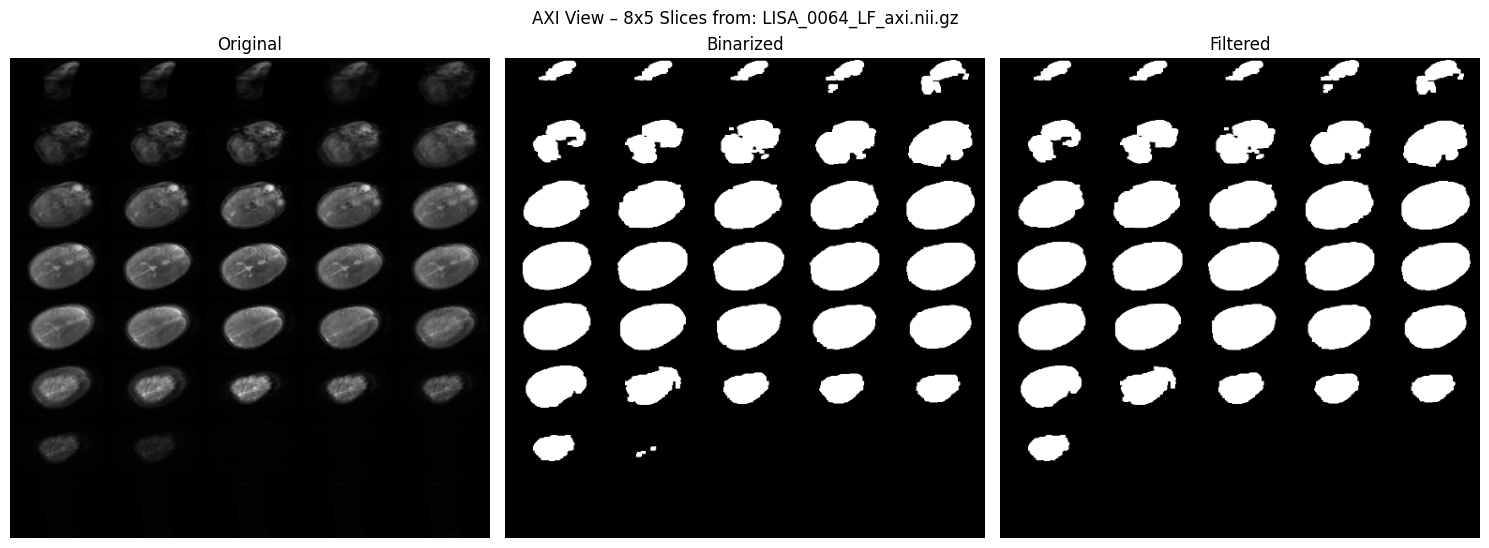

/data/cristian/projects/med_data/rise-miccai/task-1/214/155882214/LISA_2006_LF_axi.nii.gz
Noise : 2 |Zipper : 1 |Positioning : 2 |Banding : 0 |Motion : 0 |Contrast : 0 |Distortion : 0 |


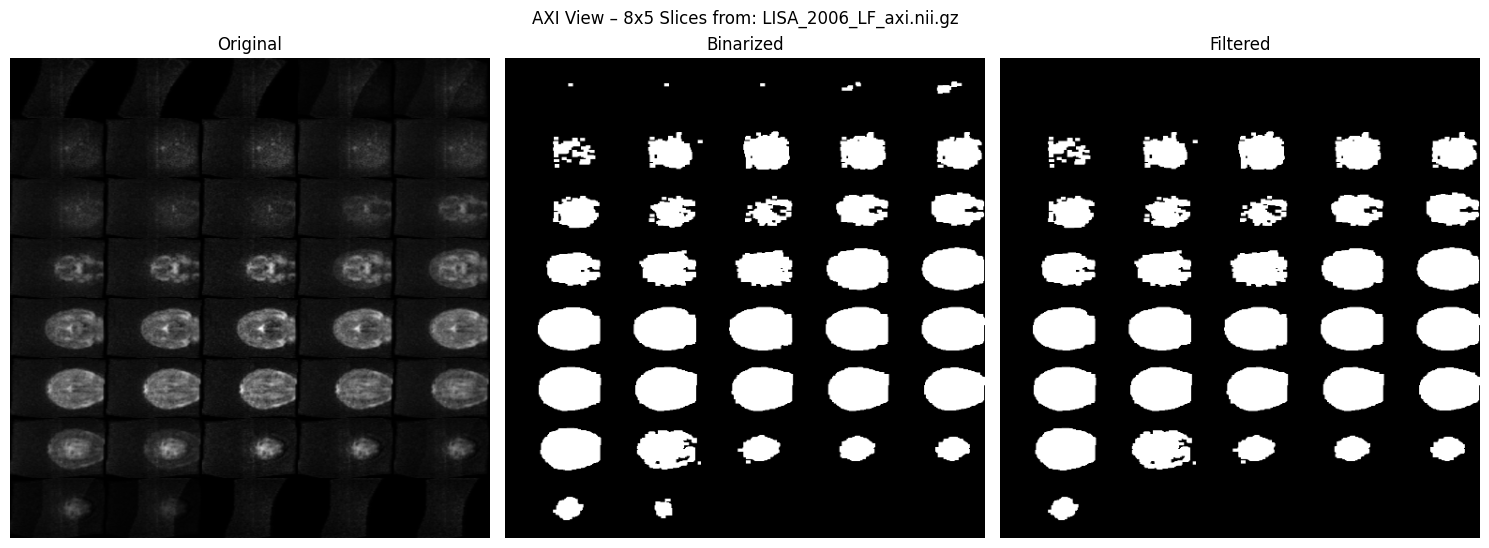

/data/cristian/projects/med_data/rise-miccai/task-1/219/155882219/LISA_2009_LF_cor.nii.gz
Noise : 0 |Zipper : 0 |Positioning : 2 |Banding : 0 |Motion : 2 |Contrast : 1 |Distortion : 2 |


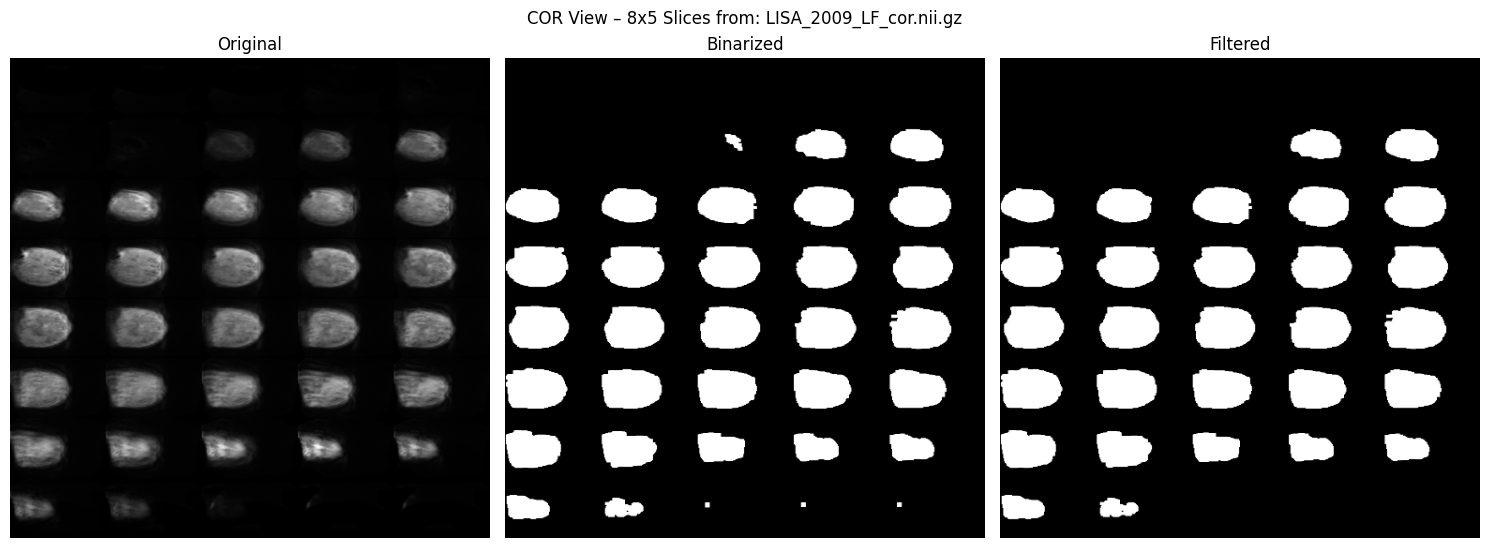

/data/cristian/projects/med_data/rise-miccai/task-1-val/219/158974219/LISA_VALIDATION_0014_LF_cor.nii.gz
don't have label


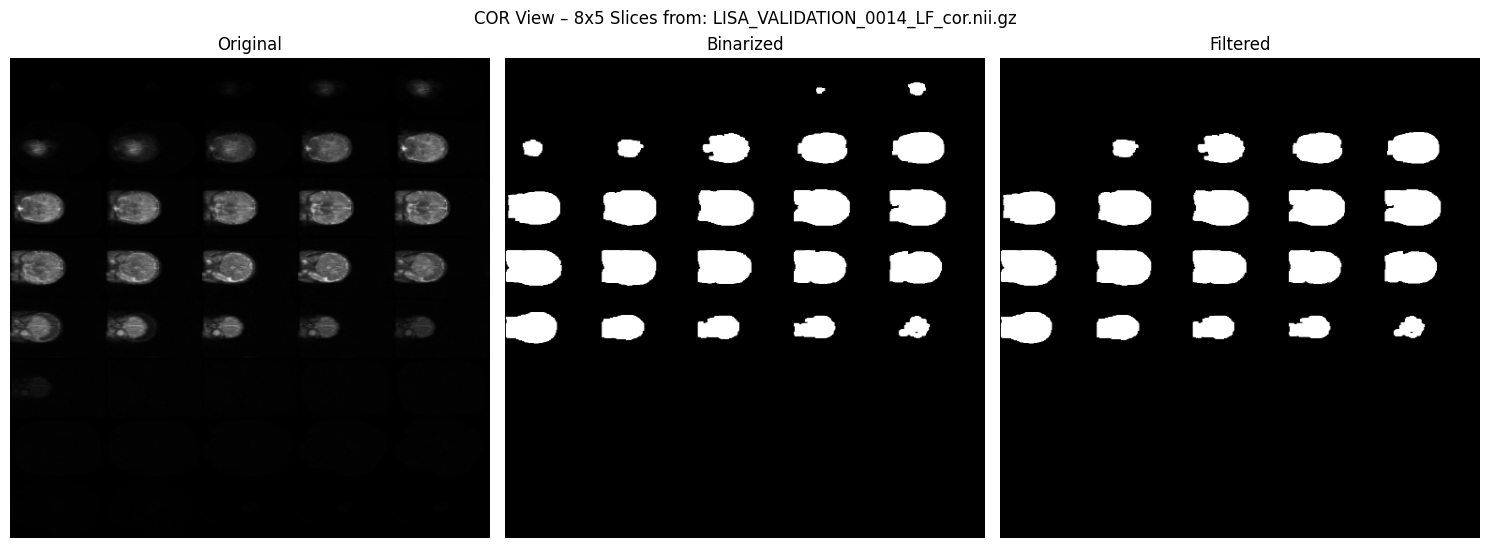

/data/cristian/projects/med_data/rise-miccai/task-1-val/180/158974180/LISA_VALIDATION_0004_LF_sag.nii.gz
don't have label


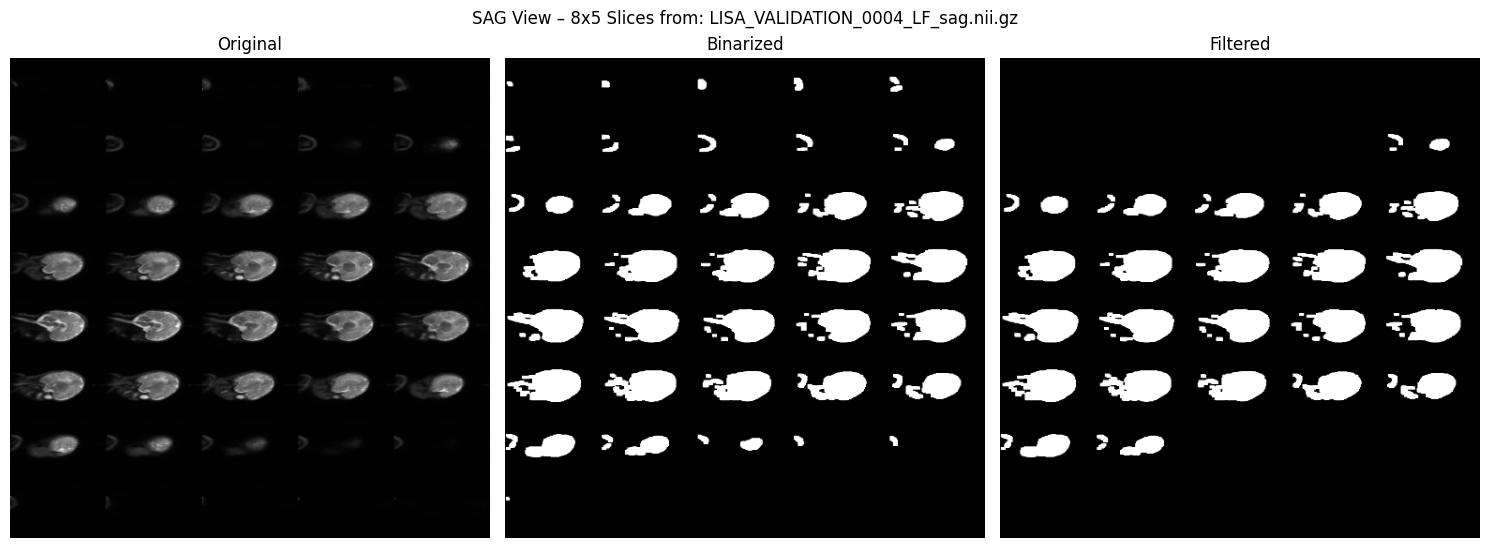

/data/cristian/projects/med_data/rise-miccai/task-1-val/179/158974179/LISA_VALIDATION_0004_LF_cor.nii.gz
don't have label


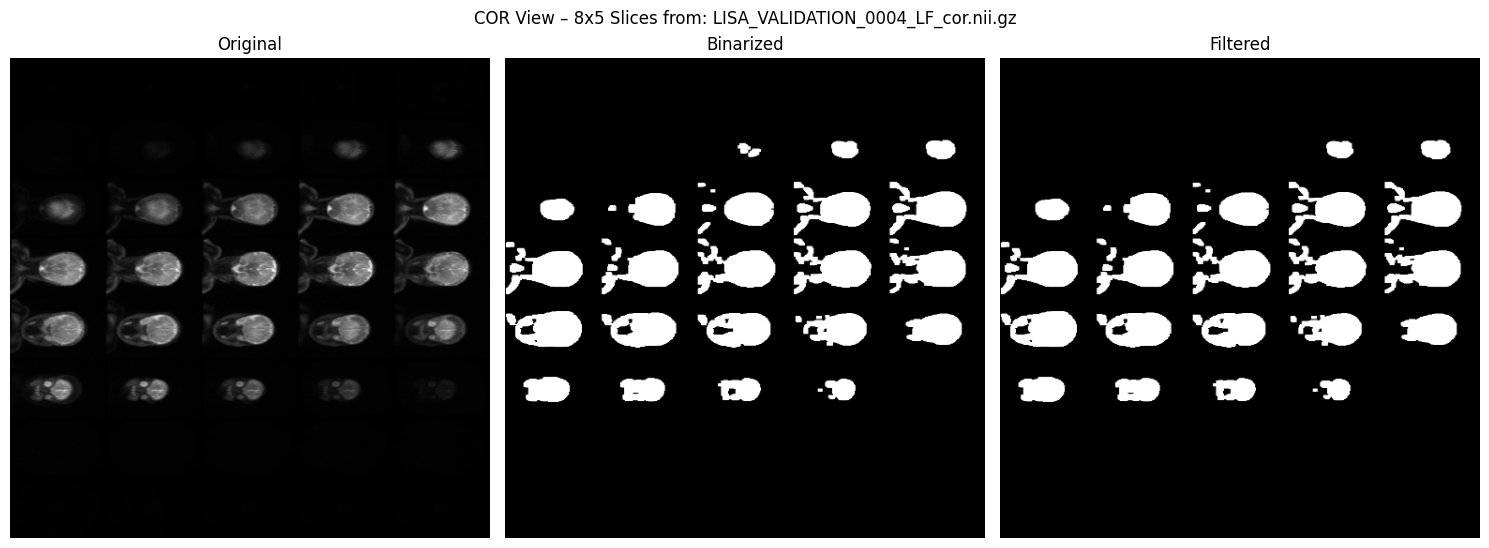

/data/cristian/projects/med_data/rise-miccai/task-1-val/178/158974178/LISA_VALIDATION_0004_LF_axi.nii.gz
don't have label


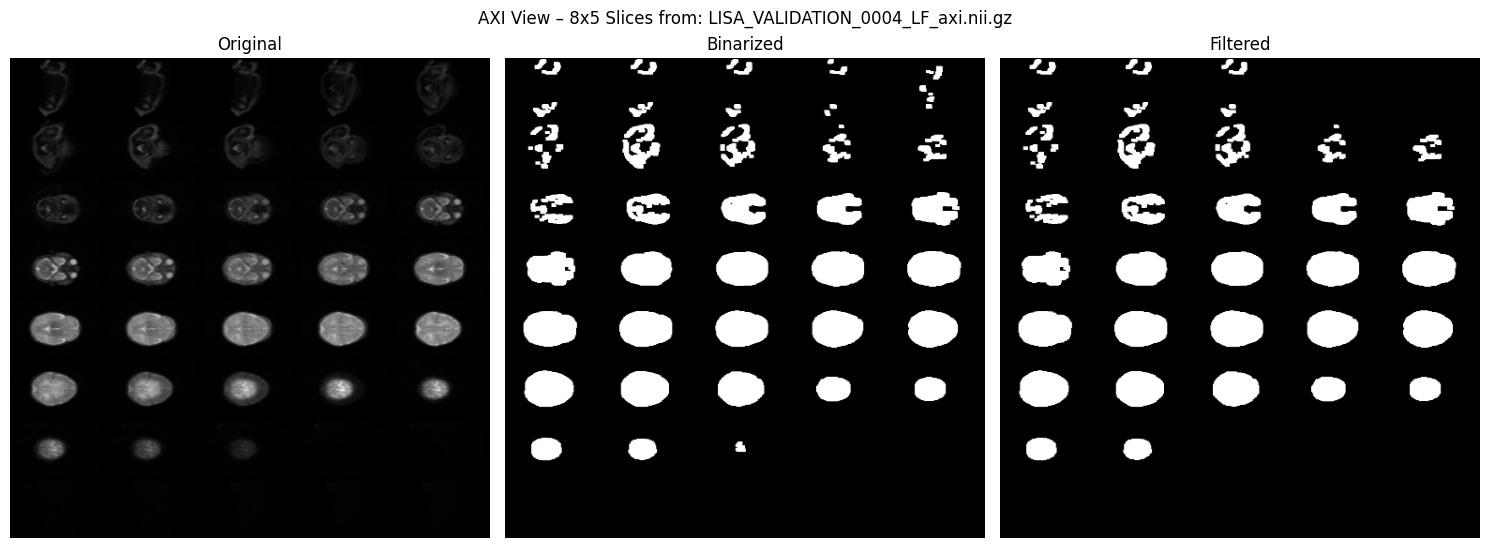

In [5]:
"""
"/data/cristian/projects/med_data/rise-miccai/task-1/255/155882255/LISA_2030_LF_axi.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/783/155881783/LISA_0067_LF_sag.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/57/155882057/LISA_1023_LF_sag.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/308/155882308/LISA_2073_LF_sag.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/223/155882223/LISA_2012_LF_sag.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/491/155881491/LISA_0022_LF_sag.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/513/159040513/LISA_2013_LF_sag.nii.gz"
"""
filenames = ["/data/cristian/projects/med_data/rise-miccai/task-1/756/155881756/LISA_0064_LF_axi.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/214/155882214/LISA_2006_LF_axi.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/219/155882219/LISA_2009_LF_cor.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1-val/219/158974219/LISA_VALIDATION_0014_LF_cor.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1-val/180/158974180/LISA_VALIDATION_0004_LF_sag.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1-val/179/158974179/LISA_VALIDATION_0004_LF_cor.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1-val/178/158974178/LISA_VALIDATION_0004_LF_axi.nii.gz"
             ]

LABELS =     ["Noise", "Zipper", "Positioning", "Banding", "Motion", "Contrast", "Distortion"]

for nifti_path in filenames:
  print(nifti_path)
  filename = nifti_path.split("/")[-1]

  try:
    df_nii = df_train[df_train["path"]==nifti_path].reset_index(drop=True)
    for label in LABELS:
      print(f"{label} : {df_nii[label][0]} |",end="")
    print()
  except:
     print("don't have label")
  # Detectar vista por nombre
  if "_sag" in filename:
      view_axis = "sag"
  elif "_cor" in filename:
      view_axis = "cor"
  elif "_axi" in filename:
      view_axis = "axi"
  else:
      raise ValueError("No se pudo detectar la vista del archivo.")

  # 📋 Crear DataFrame mock para cargar en tu Dataset
  import pandas as pd
  df = pd.DataFrame({"path": [nifti_path], "filename": [filename]})

  # 🧠 Crear dataset con tu clase
  dataset = MRIDataset3D(df, is_train=False,spatial_size=(40,120,120),labels=LABELS)

  # 🧱 Obtener volumen del archivo
  volume,_,filename,view = dataset[0]  # volume shape: (1, 96, 96, 96)

  # 🧭 Extraer slices nativos desde la vista detectada
  #tile = extract_native_tile(volume, tile_rows=4, tile_cols=4, view_axis=view_axis)
  #tile = extract_dense_slices_tile(volume, tile_rows=4, tile_cols=4, view_axis=view_axis)
  #tile = extract_centered_dense_slices_tile(volume, tile_rows=4, tile_cols=4, view_axis=view_axis)
  #tile = extract_statistically_dense_slices_tile(volume, tile_rows=4, tile_cols=4, view_axis=view_axis)
  
  tile,title_mask,title_mask_filtered = extract_dense_near_max_slices_tile(volume, tile_rows=8, tile_cols=5, view_axis=view_axis,kernel_size=5,
                                                                           reorientar=False, threshold = 0.05)

  #tile_axi = extract_dense_near_max_slices_tile(volume, tile_rows=2, tile_cols=3, view_axis="axi",kernel_size=5)
  #tile_cor = extract_dense_near_max_slices_tile(volume, tile_rows=2, tile_cols=3, view_axis="cor",kernel_size=5)
  #tile_sag = extract_dense_near_max_slices_tile(volume, tile_rows=2, tile_cols=3, view_axis="sag",kernel_size=5)
  #tile = np.vstack([tile_axi, tile_cor, tile_sag])  # (H*3, W)
  tile = cv2.resize(tile,(512,512))
  title_mask = cv2.resize(title_mask,(512,512))
  title_mask_filtered = cv2.resize(title_mask_filtered,(512,512))
  # 🎨 Visualizar
  plt.figure(figsize=(15, 6))
  plt.subplot(1,3,1)
  plt.imshow(tile, cmap="gray")
  plt.title(f"Original")
  plt.axis("off")
  plt.tight_layout()
  plt.subplot(1,3,2)
  plt.imshow(title_mask, cmap="gray")
  plt.title(f"Binarized")
  plt.axis("off")
  plt.tight_layout()
  plt.subplot(1,3,3)
  plt.imshow(title_mask_filtered, cmap="gray")
  plt.title(f"Filtered")
  plt.axis("off")
  plt.tight_layout()

  plt.suptitle(f"{view_axis.upper()} View – 8x5 Slices from: {filename}")
  plt.show()

In [28]:
df_test_imgs = pd.read_csv("../../results/preprocessed_data/df_test_imgs.csv")
print(df_test_imgs.shape,df_test_imgs["filename"].nunique())
test_df  = df_test_imgs[df_test_imgs["ratio"]>=0.2].reset_index()
print(test_df.shape,test_df["filename"].nunique())
print(set(df_test_imgs["filename"])-set(test_df["filename"]))
#test_df[test_df["filename"]=="LISA_VALIDATION_0004_LF_axi.nii.gz"]

(1680, 13) 42
(731, 14) 42
set()


In [4]:
df_train.head()

,filename,Noise,Zipper,Positioning,Banding,Motion,Contrast,Distortion,path,patient_id,dim_x,dim_y,dim_z,spacing_x,spacing_y,spacing_z,view
0,LISA_0001_LF_axi.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,36,120,146,5.0,1.5,1.5,axi
1,LISA_0001_LF_cor.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,40,120,120,5.0,1.5,1.5,cor
2,LISA_0001_LF_sag.nii.gz,0,0,0,0,0,0,1,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,36,146,120,5.0,1.5,1.5,sag
3,LISA_0002_LF_axi.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0002,40,120,146,5.0,1.5,1.5,axi
4,LISA_0002_LF_cor.nii.gz,0,0,0,0,0,0,2,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0002,40,120,134,5.0,1.5,1.5,cor


/home/va0831/env_cris/lib64/python3.9/site-packages/monai/transforms/spatial/array.py:497: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")


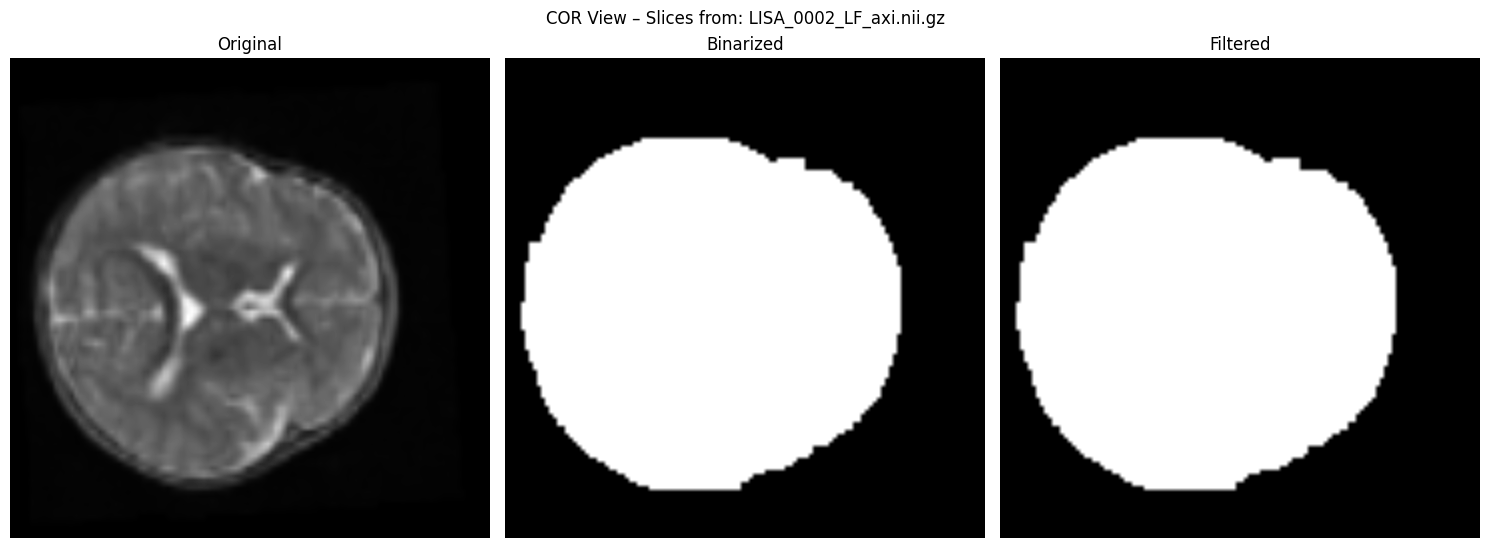

In [5]:
idx = 3
threshold = 0.1
nifti_path = df_train.loc[idx,"path"]
filename = df_train.loc[idx,"filename"]
df = pd.DataFrame({"path": [nifti_path], "filename": [filename]})
dataset = MRIDataset3D(df, is_train=False,spatial_size=(40,120,120),labels=LABELS)
volume,_,filename,view = dataset[0]
volume = volume[0].cpu().numpy()

values = []
slices_mask = []

for i in range(volume.shape[0]):
    original = copy.deepcopy(volume[i])
    mask, ratio     = preprocessor3D.morphological_operations(original)
    mask = np.array(mask, dtype=np.float32)
    slices_mask.append([mask,ratio])
    values.append(np.count_nonzero(mask))
values = np.array(values)
slices_mask_filtered = [mask*0 if ratio<threshold else mask for mask,ratio in slices_mask]

idx_slice = 20
tile = cv2.resize(volume[idx_slice],(512,512))
title_mask = cv2.resize(slices_mask[idx_slice][0],(512,512))
title_mask_filtered = cv2.resize(slices_mask_filtered[idx_slice],(512,512))

plt.figure(figsize=(15, 6))
plt.subplot(1,3,1)
plt.imshow(tile, cmap="gray")
plt.title(f"Original")
plt.axis("off")
plt.tight_layout()
plt.subplot(1,3,2)
plt.imshow(title_mask, cmap="gray")
plt.title(f"Binarized")
plt.axis("off")
plt.tight_layout()
plt.subplot(1,3,3)
plt.imshow(title_mask_filtered, cmap="gray")
plt.title(f"Filtered")
plt.axis("off")
plt.tight_layout()

plt.suptitle(f"{view_axis.upper()} View – Slices from: {filename}")
plt.show()



In [6]:
slices_mask_filtered[0].shape

(120, 120)

/data/cristian/projects/med_data/rise-miccai/task-1-val/2d_images_all/LISA_0002_LF_axi_3.png


Text(0.5, 1.0, 'Original')

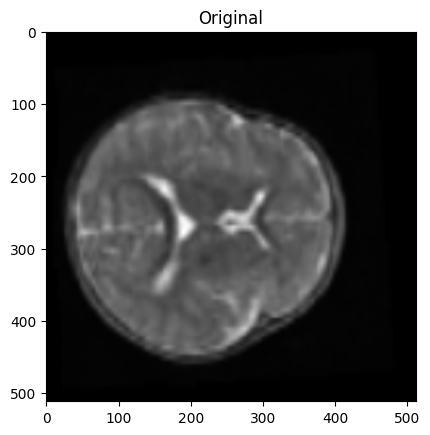

In [7]:
destination_dir = '/data/cristian/projects/med_data/rise-miccai/task-1-val/2d_images_all/'
os.makedirs(destination_dir,exist_ok=True)
img_path = os.path.join(destination_dir,filename.replace(".nii.gz",f"_{idx}.png"))
npy_path = os.path.join(destination_dir,filename.replace(".nii.gz",f"_{idx}.npy"))
print(img_path)

np.save(npy_path, tile)
plt.imsave(img_path, tile, cmap="gray")
new = plt.imread(img_path)
plt.imshow(new, cmap="gray")
plt.title(f"Original")

In [8]:
from tqdm import tqdm

destination_dir = '/data/cristian/projects/med_data/rise-miccai/task-1-val/2d_images_all/'

def pipeline_3Dto2D(df_data,destination_dir,folder=""):
  destination_dir = os.path.join(destination_dir,folder)
  os.makedirs(destination_dir,exist_ok=True)

  results = []
  for idx in tqdm(range(0,df_data.shape[0])):

    nifti_path = df_data.loc[idx,"path"]
    filename = df_data.loc[idx,"filename"]
    df = pd.DataFrame({"path": [nifti_path], "filename": [filename]})
    dataset = MRIDataset3D(df, is_train=False,spatial_size=(40,120,120),labels=LABELS)
    volume,_,filename,view = dataset[0]
    volume = volume[0].cpu().numpy()


    for idx_slice in range(volume.shape[0]):
        original = copy.deepcopy(volume[idx_slice])
        mask, ratio     = preprocessor3D.morphological_operations(original)
        mask = np.array(mask, dtype=np.float32)
        slices_mask.append([mask,ratio])
        img_path = os.path.join(destination_dir,filename.replace(".nii.gz",f"_{idx_slice}.png"))
        npy_path = os.path.join(destination_dir,filename.replace(".nii.gz",f"_{idx_slice}.npy"))
        np.save(npy_path, volume[idx_slice])
        plt.imsave(img_path, volume[idx_slice], cmap="gray")

        values= {"filename":filename,"img_path":img_path,"npy_path":npy_path}
        results.append(values)
  return results

In [9]:
results_train = pipeline_3Dto2D(df_train[:10],destination_dir,folder="train")
df_results_train = pd.DataFrame(results_train)
df_train = df_train.merge(df_results_train,on=["filename"],how="left")
df_train.head()

100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


,filename,Noise,Zipper,Positioning,Banding,Motion,Contrast,Distortion,path,patient_id,dim_x,dim_y,dim_z,spacing_x,spacing_y,spacing_z,view,img_path,npy_path
0,LISA_0001_LF_axi.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...
1,LISA_0001_LF_axi.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...
2,LISA_0001_LF_axi.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...
3,LISA_0001_LF_axi.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...
4,LISA_0001_LF_axi.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...


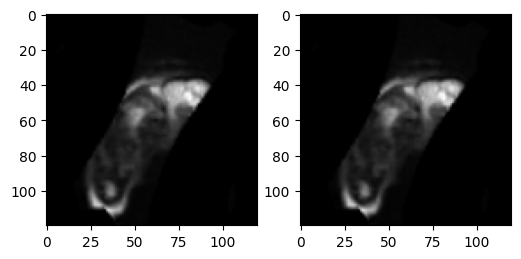

In [10]:
npy_img = np.load(df_train["npy_path"][0])
img = plt.imread(df_train["img_path"][0])
fig = plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(npy_img,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(img)
plt.show()

In [11]:
results_test = pipeline_3Dto2D(df_test[:10],destination_dir,folder="test")
df_results_test = pd.DataFrame(results_test)
df_test = df_test.merge(df_results_test,on=["filename"],how="left")
df_test.head()

  0%|          | 0/10 [00:00<?, ?it/s]/home/va0831/env_cris/lib64/python3.9/site-packages/monai/transforms/spatial/array.py:497: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")
100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


,path,filename,patient_id,dim_x,dim_y,dim_z,spacing_x,spacing_y,spacing_z,view,img_path,npy_path
0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_VALIDATION_0001_LF_axi.nii.gz,LISA_VALIDATION_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...
1,/data/cristian/projects/med_data/rise-miccai/t...,LISA_VALIDATION_0001_LF_axi.nii.gz,LISA_VALIDATION_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...
2,/data/cristian/projects/med_data/rise-miccai/t...,LISA_VALIDATION_0001_LF_axi.nii.gz,LISA_VALIDATION_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...
3,/data/cristian/projects/med_data/rise-miccai/t...,LISA_VALIDATION_0001_LF_axi.nii.gz,LISA_VALIDATION_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...
4,/data/cristian/projects/med_data/rise-miccai/t...,LISA_VALIDATION_0001_LF_axi.nii.gz,LISA_VALIDATION_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...
